In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!cp -r /content/drive/MyDrive/food_dataset /content/

Original dataset size: 2836
Training set size: 2268
Validation set size: 568
Augmented training set size: 6804
Test set size: 948
Augmented Training Samples:


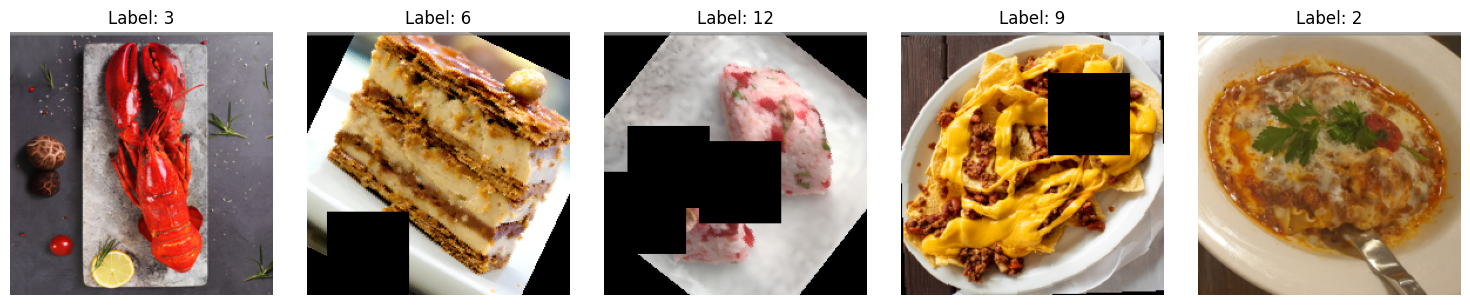

Validation Samples:


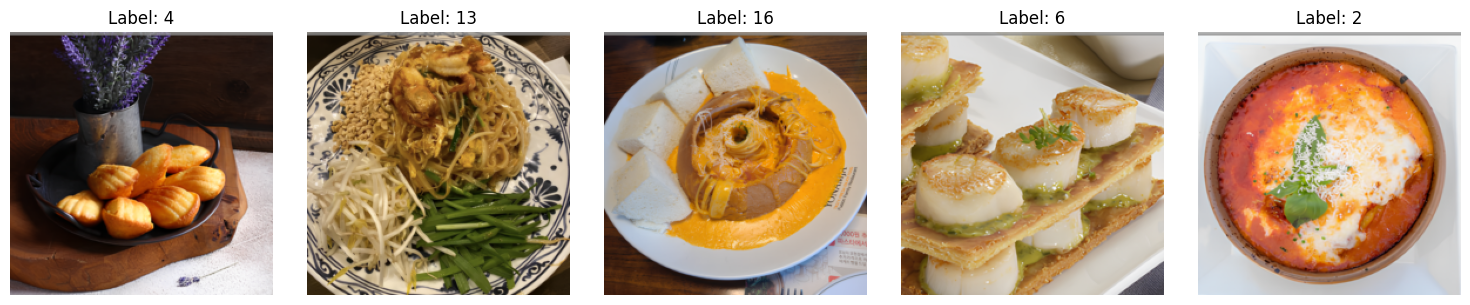

Test Samples:


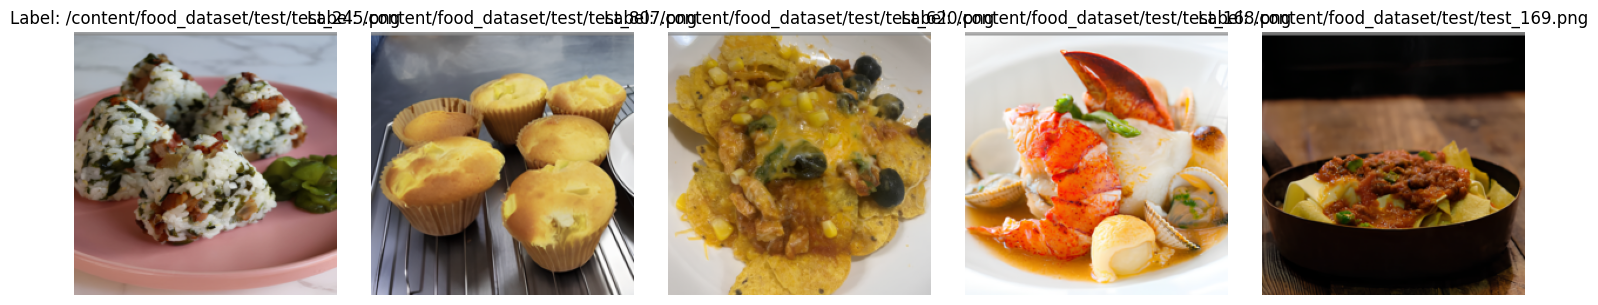

In [13]:
import os
import torch
import torchvision.transforms as transforms
import random
from PIL import Image
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import datasets, models
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from IPython.display import clear_output

class RandomCutout(object):
    def __init__(self, n_holes=1, length=16):
        self.n_holes = n_holes
        self.length = length

    def __call__(self, img):
        if isinstance(img, torch.Tensor):
            img = transforms.ToPILImage()(img)

        h, w = img.size
        mask = Image.new('L', (w, h), 255)

        holes = random.randint(1, self.n_holes)
        for _ in range(holes):
            size = min(h, w, self.length)
            y = random.randint(0, h - size)
            x = random.randint(0, w - size)

            y1 = max(0, y)
            y2 = min(h, y + size)
            x1 = max(0, x)
            x2 = min(w, x + size)

            mask.paste(0, (x1, y1, x2, y2))

        img = Image.composite(img, Image.new(img.mode, img.size, 0), mask)
        return img

class AugmentedDataset(Dataset):
    def __init__(self, original_dataset, augmentations, num_augments=1):
        self.original_dataset = original_dataset
        self.augmentations = augmentations
        self.num_augments = num_augments

    def __len__(self):
        return len(self.original_dataset) * (self.num_augments + 1)

    def __getitem__(self, idx):
        original_idx = idx % len(self.original_dataset)
        img, label = self.original_dataset[original_idx]

        if idx >= len(self.original_dataset):
            aug_idx = random.randint(0, len(self.augmentations) - 1)
            if isinstance(img, torch.Tensor):
                img = transforms.ToPILImage()(img)
            img = self.augmentations[aug_idx](img)

        if not isinstance(img, torch.Tensor):
            img = transforms.ToTensor()(img)

        return img, label

def denormalize(img_tensor):
    mean = torch.tensor([0.485, 0.456, 0.406])
    std = torch.tensor([0.229, 0.224, 0.225])
    img_tensor = img_tensor.clone()
    for t, m, s in zip(img_tensor, mean, std):
        t.mul_(s).add_(m)
    return img_tensor

train_data_dir = '/content/food_dataset/train'
test_data_dir = '/content/food_dataset/test'

normalize_transform = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

original_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

original_dataset = datasets.ImageFolder(train_data_dir, transform=original_transform)

train_size = int(0.8 * len(original_dataset))
val_size = len(original_dataset) - train_size
train_dataset, val_dataset = random_split(original_dataset, [train_size, val_size])

augmentation_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(60),
    RandomCutout(n_holes=3, length=70),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

augmented_train_dataset = AugmentedDataset(train_dataset, augmentations=[augmentation_transform], num_augments=2)
augmented_train_loader = DataLoader(augmented_train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)

class TestDataset(Dataset):
    def __init__(self, img_dir, transform=None):
        self.img_dir = img_dir
        self.transform = transform
        self.img_paths = [os.path.join(img_dir, img) for img in os.listdir(img_dir)]

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        img = Image.open(img_path).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img, img_path

test_dataset = TestDataset(test_data_dir, transform=original_transform)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

def show_samples(dataset, num_samples=5):
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 3))
    for i in range(num_samples):
        idx = random.randint(0, len(dataset) - 1)
        img, label = dataset[idx]
        if img.ndim == 4:
            img = img.squeeze(0)
        img = img.permute(1, 2, 0)
        img = denormalize(img)
        img = img.clamp(0, 1).numpy()
        axes[i].imshow(img)
        axes[i].axis('off')
        axes[i].set_title(f'Label: {label}')
    plt.tight_layout()
    plt.show()

print(f"Original dataset size: {len(original_dataset)}")
print(f"Training set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")
print(f"Augmented training set size: {len(augmented_train_dataset)}")
print(f"Test set size: {len(test_dataset)}")

print("Augmented Training Samples:")
show_samples(augmented_train_dataset)

print("Validation Samples:")
show_samples(val_dataset)

print("Test Samples:")
show_samples(test_dataset)

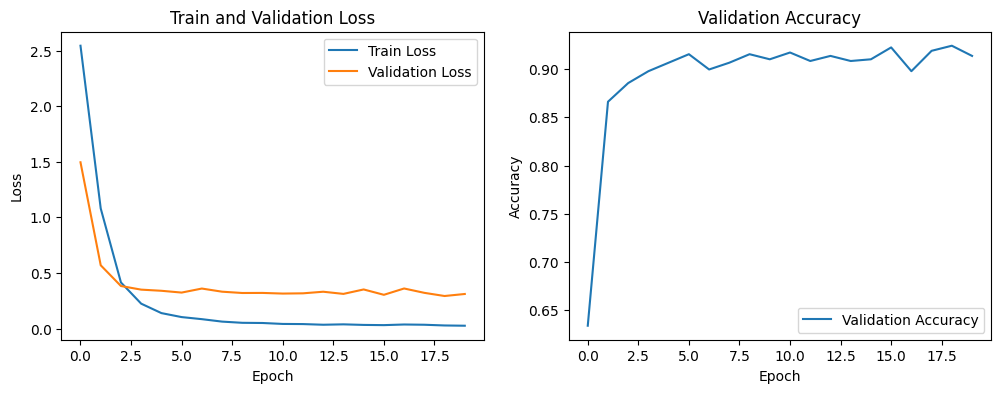

<All keys matched successfully>

In [4]:
import matplotlib.pyplot as plt
from IPython.display import clear_output
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader, Dataset, random_split
import os
from torch.optim import lr_scheduler
from torchvision.models import VGG16_Weights, ResNet50_Weights, Inception_V3_Weights

class EarlyStopping:
    def __init__(self, patience=7, verbose=False, delta=0):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = float('inf')
        self.delta = delta

    def __call__(self, val_loss, model):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decreases.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), 'checkpoint.pt')
        self.val_loss_min = val_loss

class EnsembleModel(nn.Module):
    def __init__(self, num_classes):
        super(EnsembleModel, self).__init__()
        self.vgg16 = self.create_vgg16_model(num_classes)
        self.resnet50 = self.create_resnet50_model(num_classes)
        self.inceptionv3 = self.create_inceptionv3_model(num_classes)

        self.transform_vgg_resnet = transforms.Resize((224, 224))
        self.transform_inception = transforms.Resize((299, 299))

    def forward(self, x):
        x_vgg_resnet = self.transform_vgg_resnet(x)
        x_inception = self.transform_inception(x)

        vgg16_output = self.vgg16(x_vgg_resnet)
        resnet50_output = self.resnet50(x_vgg_resnet)

        if self.training:
            inceptionv3_output, _ = self.inceptionv3(x_inception)
        else:
            inceptionv3_output = self.inceptionv3(x_inception)

        avg_output = (vgg16_output + resnet50_output + inceptionv3_output) / 3
        return avg_output

    def create_vgg16_model(self, num_classes):
        model = models.vgg16(weights=VGG16_Weights.IMAGENET1K_V1)
        for param in model.parameters():
            param.requires_grad = False
        for param in model.classifier[6].parameters():
            param.requires_grad = True
        model.classifier[6] = nn.Sequential(
            nn.Linear(model.classifier[6].in_features, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes),
            nn.LogSoftmax(dim=1)
        )
        return model

    def create_resnet50_model(self, num_classes):
        model = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
        for name, param in model.named_parameters():
            param.requires_grad = False
        for name, param in model.layer4.named_parameters():
            param.requires_grad = True
        for name, param in model.fc.named_parameters():
            param.requires_grad = True
        num_features = model.fc.in_features
        model.fc = nn.Sequential(
            nn.Linear(num_features, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes),
            nn.LogSoftmax(dim=1)
        )
        return model

    def create_inceptionv3_model(self, num_classes):
        model = models.inception_v3(weights=Inception_V3_Weights.IMAGENET1K_V1)
        for param in model.parameters():
            param.requires_grad = False
        for param in model.fc.parameters():
            param.requires_grad = True
        num_features = model.fc.in_features
        model.fc = nn.Sequential(
            nn.Linear(num_features, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes),
            nn.LogSoftmax(dim=1)
        )
        return model

num_classes = 19
model = EnsembleModel(num_classes)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.0001, weight_decay=1e-6)
exp_lr_scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)

early_stopping = EarlyStopping(patience=7, verbose=True)

train_losses = []
val_losses = []
val_accuracies = []

num_epochs = 20
best_val_acc = 0.0

checkpoint_dir = '/content/checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in augmented_train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)

    epoch_loss = running_loss / len(augmented_train_loader.dataset)
    train_losses.append(epoch_loss)
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}')

    model.eval()
    val_loss = 0.0
    corrects = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            corrects += torch.sum(preds == labels.data)

    val_loss = val_loss / len(val_loader.dataset)
    val_acc = corrects.double() / len(val_loader.dataset)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc.item())
    print(f'Validation Loss: {val_loss:.4f}, Accuracy: {val_acc:.4f}')

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        checkpoint_path = os.path.join(checkpoint_dir, f'model_epoch_{epoch+1}_acc_{val_acc:.4f}.pth')
        torch.save(model.state_dict(), checkpoint_path)
        print(f'Model saved to {checkpoint_path}')

    early_stopping(val_loss, model)

    if early_stopping.early_stop:
        print("Early stopping")
        break

    exp_lr_scheduler.step(val_loss)

    clear_output(wait=True)
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Train and Validation Loss')

    plt.subplot(1, 2, 2)
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Validation Accuracy')

    plt.show()

model.load_state_dict(torch.load('checkpoint.pt'))

In [14]:
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import os
from torchvision import transforms

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def evaluate_ensemble_model(model, test_loader, output_path):
    model.eval()
    predictions = []
    filenames = []

    with torch.no_grad():
        for inputs, paths in test_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            predictions.extend(preds.cpu().numpy())
            filenames.extend(paths)

    filenames = [os.path.basename(filename) for filename in filenames]
    results = pd.DataFrame({"ID": filenames, "Pred": predictions})
    results.to_csv(output_path, index=False)
    return results

model.load_state_dict(torch.load('checkpoint.pt'))

# 모델 평가 및 결과 저장
output_path = '/content/ensemble_predictions.csv'
ensemble_results = evaluate_ensemble_model(model, test_loader, output_path)
print(ensemble_results.head())


             ID  Pred
0  test_562.png    11
1  test_451.png     1
2  test_323.png    16
3  test_408.png     1
4  test_505.png    18


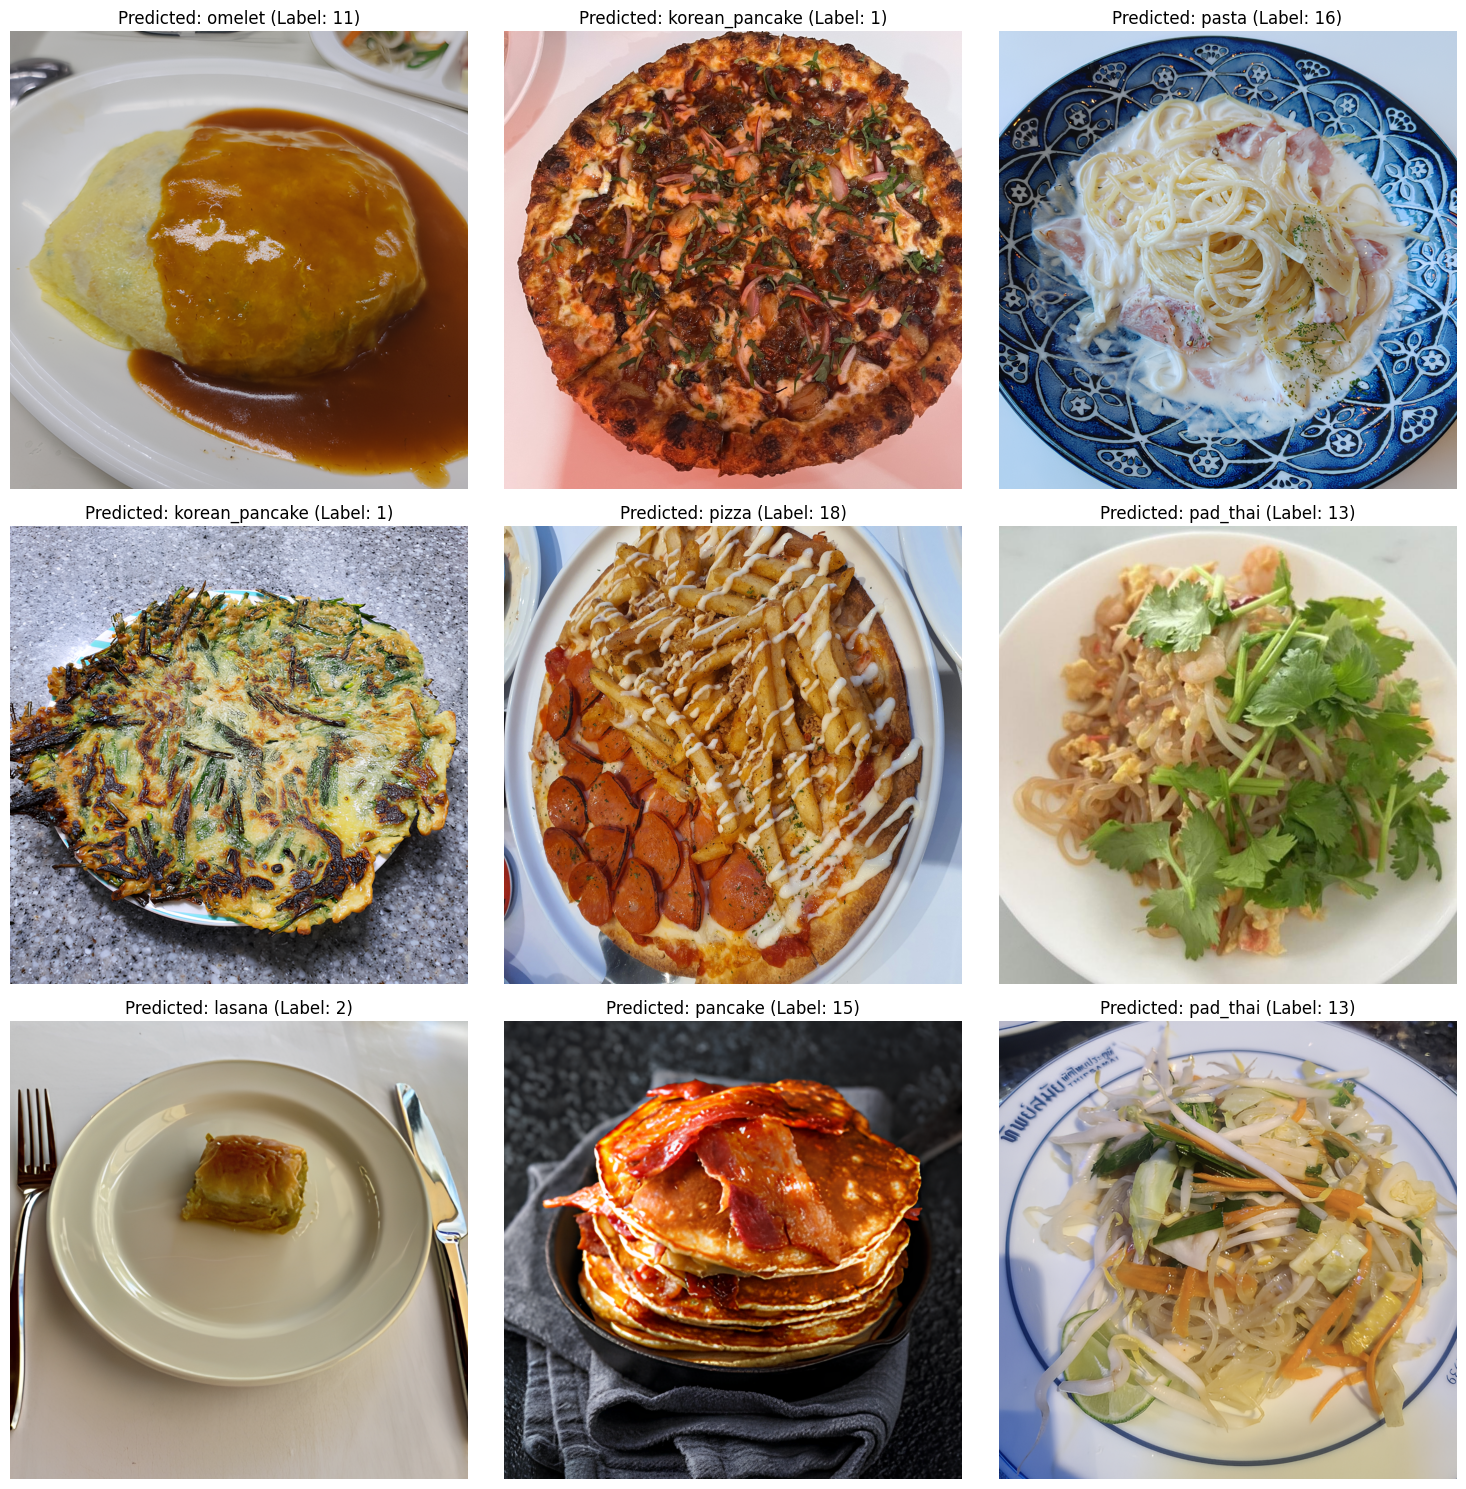

In [15]:
import matplotlib.pyplot as plt
import os
from PIL import Image
import pandas as pd
import numpy as np

label_to_class = {
    0: "kimchi_stew", 1: "korean_pancake", 2: "lasana", 3: "lobster", 4: "madeleine",
    5: "mapa_tofu", 6: "milfeuille", 7: "muffin", 8: "naan", 9: "nachos",
    10: "nasi_goreng", 11: "omelet", 12: "onigiri", 13: "pad_thai", 14: "paea",
    15: "pancake", 16: "pasta", 17: "pie", 18: "pizza"
}

def display_images_in_grid(results, test_data_dir, num_images=9):
    fig, axes = plt.subplots(3, 3, figsize=(15, 15))

    for idx, (index, row) in enumerate(results.iterrows()):
        if idx >= num_images:
            break
        img_path = os.path.join(test_data_dir, row['ID'])
        try:
            img = Image.open(img_path).convert("RGB")
            img = np.array(img)
        except (IOError, SyntaxError) as e:
            print(f"Skipping {img_path}, not a valid image")
            continue

        predicted_name = label_to_class.get(row['Pred'], 'Unknown')

        ax = axes[idx // 3, idx % 3]
        ax.imshow(img)
        ax.set_title(f"Predicted: {predicted_name} (Label: {row['Pred']})")
        ax.axis('off')

    plt.tight_layout()
    plt.show()

results_path = '/content/ensemble_predictions.csv'

results = pd.read_csv(results_path)

display_images_in_grid(results, test_data_dir, num_images=9)